## List of Imports 

In [1]:
from __future__ import print_function, division

In [2]:
import pickle
import itertools 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.learning_curve import learning_curve

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split


%matplotlib inline 

/Users/liyuqiao/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/liyuqiao/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


## Loading Data & More Detailed Analysis

In [3]:
with open('../../Data/train_standardized.pickle', 'rb') as f:
    X_train = pickle.load(f)
    
with open('../../Data/test_transformed.pickle', 'rb') as f2: 
    X_test = pickle.load(f2)
    
with open('../../Data/train_target.pickle', 'rb') as f3: 
    y_train = pickle.load(f3) 

with open('../../Data/test_target.pickle', 'rb') as f4: 
    y_test = pickle.load(f4) 

with open('../../Data/cuisine_clean.pickle', 'rb') as f5: 
    df_cuisine = pickle.load(f5) 

In [4]:
df_cuisine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Columns: 589 entries, cuisine to zucchini
dtypes: int64(587), object(2)
memory usage: 178.7+ MB


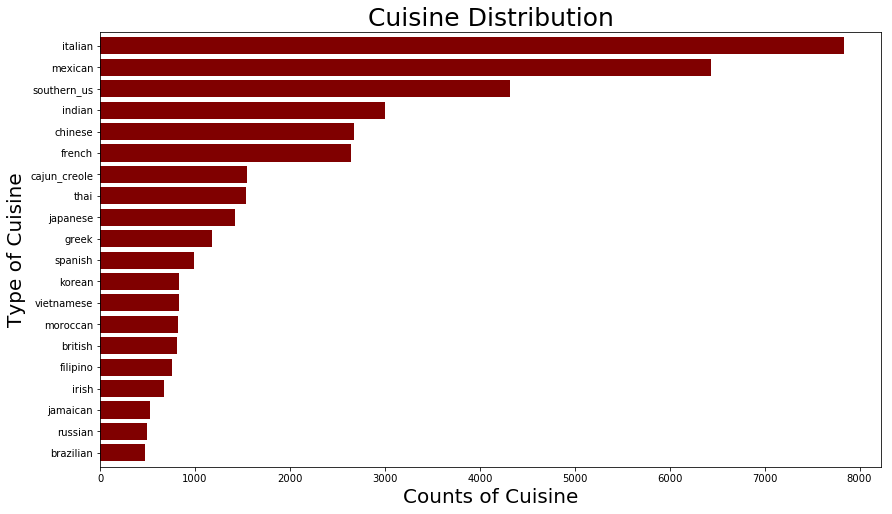

In [5]:
cuisine_counts = df_cuisine['cuisine'].value_counts().sort_values()
cuisine_counts.plot(kind='barh',color = 'maroon'
                    ,linewidth=10,width=0.8,align='center',figsize =(14,8))
plt.xlabel('Counts of Cuisine', fontsize=20)
plt.ylabel('Type of Cuisine', fontsize=20)
plt.title('Cuisine Distribution', fontsize=25)

# plt.savefig('../../Visuals/cuisinedistribution.png'
#             , dpi=200, bbox_inches = 'tight')

## Modeling - Set model performance baseline 
Given the dominance of Italian food in the training set, the first model will predict 'italian' all the time. This is to establish a baseline for model performance and see how much I can improve on performance through employing different models and approaches. 

In [6]:
def predict_italian(input_x):
    italian = ['italian']*(len(input_x))
    return italian 

In [7]:
x1 = df_cuisine.iloc[:,3:]
y = df_cuisine['cuisine']

In [8]:
pred_itl = predict_italian(x1)
itl_score = accuracy_score(y, pred_itl)
print("The baseline in terms of model accuracy is: ", itl_score)

The baseline in terms of model accuracy is:  0.197063408257


## Modeling - Try different classification estimators 
 * Logistic Regression
 * LinearSVC  
 * Bernoull Naive Bayes 
 * Decision Tree
 * Random Forest 

## Building pipelines for modeling

#### 1). Model w/ parameter tuning not using GridSearchCV (manually instead)

In [9]:
# GridSearch takes a long time to run for this dataset, so the 
# below function can be utilized to speed up the training process. 

def modeling(estimator, X_train, y_train, X_test, y_test):
    """ This function trains a model and returns the test score. """
    estimator = estimator.fit(X_train, y_train)
    pred_tr = estimator.predict(X_train)
    pred_tt = estimator.predict(X_test)
    score_tr = accuracy_score(y_train, pred_tr)
    score_tt = accuracy_score(y_test, pred_tt)
    score_f1 = f1_score(y_test, pred_tt,average='macro')
    score_precision = precision_score(y_test, pred_tt,average="macro")
    score_recall = recall_score(y_test, pred_tt,average="macro")
    
    print('|Accuracy on Training|: ', score_tr
          ,'\n','|Accuracy on Testing|: ', score_tt,'\n'
          ,'|F1 Score|: ', score_f1)
    
    return pred_tt, estimator, score_tt, score_f1

#### 2). Model w/ parameter tuning using GridSearchCV 
#### Initiate cross-validation iterator

In [10]:
cv = ShuffleSplit(X_train.shape[0], random_state=7777)

#### Tune the hyperparameters and build model 

In [11]:
# def model_initiation(estimator, X, y, cv, param_grid):
#     """ This function returns the best estimator by using 
#     GridSearchCV to test on 
#     different combinations of parameters. """
#     classifier = GridSearchCV(estimator, param_grid
#     , cv=cv, scoring='accuracy')
#     classifier.fit(X,y)
    
#     best_estimator = classifier.best_estimator_
#     best_score = classifier.best_score_
#     best_params = classifier.best_params_
    
#     print('|Best Model|: ----------', best_estimator
#           ,'\n','|Highest Accuracy on Training|: ----------'
#     , best_score_lr)
    
#     return best_estimator 

#### Debug algorithm with learning curve 
X_train is randomly split into a training and a test set 10 times (n_iter=10). Each point on the training-score curve is the average of 10 scores where the model was trained and evaluated on the first i training examples. Each point on the cross-validation score curve is the average of 10 scores where the model was trained on the first i training examples and evaluated on all examples of the test set.

In [12]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """ This function plots the learning curve. """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std
                     , alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#### Evaluate on the test set

In [13]:
# def model_prediction(best_estimator, x, y):
#     prediction = best_estimator.predict(x)
#     test_score = accuracy_score(y, prediction)
#     # test_score = classifier.score(X_test, y_test)
    
#     print('|Accuracy on Testing|: ', test_score)
    
#     return test_score,prediction 

#### Cross validation scores 

In [14]:
def cross_val_scores(best_model,x,y):
    score = cross_val_score(best_model, x, y, cv=10)
    return score

#### Plot confusion matrix 

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.RdGy):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

### Classification Estimator 1: Logistic Regression

In [16]:
# Initiates parameters:  
# Uses grid search to find out the best C value.
# Basically smaller C specify stronger regularization.

# parameters_lr = {'C': [0.01, 0.1, 1, 10] }  

# Initiates estimator: 
# Can play around with C value here if not with GridSearchCV
estimator_lr = LogisticRegression(C=10)

# W/o GridSearchCV parameter-tuning 
result_lr = modeling(estimator_lr, X_train, y_train, X_test, y_test)

|Accuracy on Training|:  0.726518444021 
 |Accuracy on Testing|:  0.692952317104 
 |F1 Score|:  0.573853686575


In [17]:
# W/ GridSearchCV parameter-tuning 

# best_lr = model_initiation(estimator_lr, X_train, y_train
#                            , cv=cv, param_grid=parameters_lr)

# result_lr = model_prediction(best_lr, X_test, y_test)

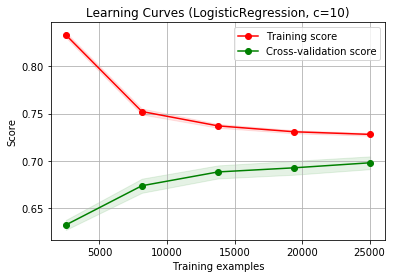

In [18]:
model_lr = result_lr[1]
title_lr = 'Learning Curves (LogisticRegression, c=10)' 
plot_learning_curve(model_lr, title_lr, X_train, y_train, cv=10)
# plt.savefig('../../Visuals/learningcurve_lr.png'
#             , dpi=200, bbox_inches = 'tight')

In [154]:
df_test = pd.DataFrame(y_test)

In [155]:
df_test['predicted_lr'] = result_lr[0]
df_test.head(10)

,cuisine,predicted_lr
26745,cajun_creole,cajun_creole
2842,mexican,mexican
36766,spanish,mexican
19107,moroccan,mexican
38651,japanese,southern_us
11251,italian,italian
8109,korean,italian
20919,british,irish
2472,southern_us,southern_us
36048,mexican,italian


In [156]:
print(classification_report(y_test, result_lr[0]))

              precision    recall  f1-score   support

   brazilian       0.41      0.21      0.27       135
     british       0.36      0.14      0.20       221
cajun_creole       0.72      0.65      0.68       486
     chinese       0.72      0.80      0.76       778
    filipino       0.60      0.36      0.45       233
      french       0.50      0.49      0.50       774
       greek       0.69      0.59      0.63       354
      indian       0.84      0.84      0.84       876
       irish       0.48      0.27      0.34       190
     italian       0.70      0.85      0.77      2352
    jamaican       0.67      0.51      0.58       154
    japanese       0.77      0.51      0.61       459
      korean       0.69      0.64      0.67       257
     mexican       0.84      0.88      0.86      1929
    moroccan       0.78      0.69      0.73       243
     russian       0.59      0.30      0.40       156
 southern_us       0.55      0.68      0.61      1346
     spanish       0.47    

### Classification Estimator: Linear Support Vector Classification
* Same process applies:
    1. Choose estimator
    2. Choose cross-validation iterator
    3. Tune the hyperparameters
    4. Debug algorithm with learning curve
    5. Evaluate on the test set

In [19]:
# Initiates estimator: 
# Played around with C and multi_class parameters (ovr and crammer_singer)
estimator_svc = LinearSVC(random_state=7777,penalty='l2', C=10)
result_svc = modeling(estimator_svc, X_train, y_train, X_test, y_test)

|Accuracy on Training|:  0.71990948601 
 |Accuracy on Testing|:  0.688762255929 
 |F1 Score|:  0.558827170468


In [158]:
# W/ GridSearchCV 

# best_svc = model_initiation(estimator_svc
#, X_train, y_train, cv=cv, param_grid=parameters_svc)

# result_svc = model_prediction(best_svc, X_test, y_test)

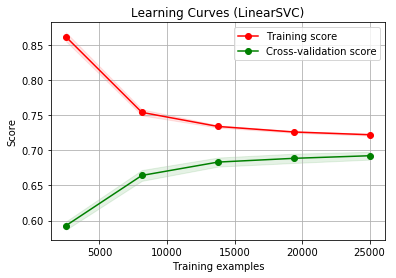

In [20]:
model_svc = result_svc[1]
title_svc = 'Learning Curves (LinearSVC)' 
plot_learning_curve(model_svc, title_svc, X_train, y_train, cv=10)
# plt.savefig('../../Visuals/learningcurve_svc.png'
#             , dpi=200, bbox_inches = 'tight')

In [160]:
df_test['predicted_svc'] = result_svc[0]
df_test.head(10)

,cuisine,predicted_lr,predicted_svc
26745,cajun_creole,cajun_creole,cajun_creole
2842,mexican,mexican,mexican
36766,spanish,mexican,mexican
19107,moroccan,mexican,mexican
38651,japanese,southern_us,southern_us
11251,italian,italian,italian
8109,korean,italian,cajun_creole
20919,british,irish,southern_us
2472,southern_us,southern_us,southern_us
36048,mexican,italian,italian


In [161]:
print(classification_report(y_test, result_svc[0]))

              precision    recall  f1-score   support

   brazilian       0.43      0.15      0.22       135
     british       0.38      0.10      0.16       221
cajun_creole       0.68      0.64      0.66       486
     chinese       0.70      0.81      0.75       778
    filipino       0.62      0.30      0.40       233
      french       0.51      0.48      0.49       774
       greek       0.70      0.58      0.64       354
      indian       0.83      0.84      0.83       876
       irish       0.48      0.24      0.32       190
     italian       0.69      0.86      0.77      2352
    jamaican       0.61      0.52      0.56       154
    japanese       0.81      0.49      0.61       459
      korean       0.69      0.64      0.67       257
     mexican       0.83      0.88      0.86      1929
    moroccan       0.70      0.70      0.70       243
     russian       0.55      0.26      0.36       156
 southern_us       0.54      0.68      0.60      1346
     spanish       0.54    

### Classification Estimator: Random Forest
* Same process applies:
    1. Choose estimator
    2. Choose cross-validation iterator
    3. Tune the hyperparameters
    4. Debug algorithm with learning curve
    5. Evaluate on the test set
    6. Test over-fitting in model selection 

In [21]:
estimator_rf = RandomForestClassifier(random_state=7777
                                      ,max_features='sqrt'
                                      ,n_estimators=85
                                      ,min_samples_split=10
                                      ,n_jobs=-1
                                      ,oob_score=True)
result_rf = modeling(estimator_rf, X_train, y_train, X_test, y_test)

|Accuracy on Training|:  0.888258324054 
 |Accuracy on Testing|:  0.690354479175 
 |F1 Score|:  0.5719763857


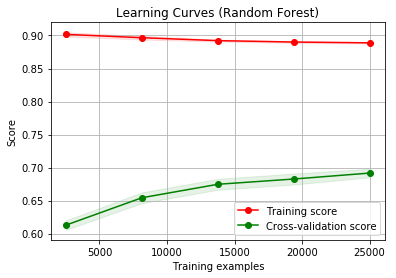

In [22]:
model_rf = result_rf[1]
title_rf = 'Learning Curves (Random Forest)' 
plot_learning_curve(model_rf, title_rf, X_train, y_train, cv=10)
# plt.savefig('../../Visuals/learningcurve_rf.png'
#             , dpi=200, bbox_inches = 'tight')

In [164]:
df_test['predicted_rf'] = result_rf[0]
df_test.head(10)

,cuisine,predicted_lr,predicted_svc,predicted_rf
26745,cajun_creole,cajun_creole,cajun_creole,cajun_creole
2842,mexican,mexican,mexican,mexican
36766,spanish,mexican,mexican,mexican
19107,moroccan,mexican,mexican,indian
38651,japanese,southern_us,southern_us,southern_us
11251,italian,italian,italian,italian
8109,korean,italian,cajun_creole,cajun_creole
20919,british,irish,southern_us,southern_us
2472,southern_us,southern_us,southern_us,southern_us
36048,mexican,italian,italian,southern_us


In [165]:
print(classification_report(y_test, result_rf[0]))

              precision    recall  f1-score   support

   brazilian       0.50      0.28      0.36       135
     british       0.34      0.19      0.24       221
cajun_creole       0.72      0.65      0.68       486
     chinese       0.69      0.82      0.75       778
    filipino       0.63      0.35      0.45       233
      french       0.47      0.46      0.47       774
       greek       0.72      0.59      0.65       354
      indian       0.78      0.87      0.83       876
       irish       0.48      0.31      0.37       190
     italian       0.71      0.84      0.77      2352
    jamaican       0.70      0.49      0.57       154
    japanese       0.73      0.54      0.62       459
      korean       0.72      0.54      0.62       257
     mexican       0.80      0.88      0.84      1929
    moroccan       0.81      0.61      0.69       243
     russian       0.59      0.26      0.36       156
 southern_us       0.58      0.67      0.62      1346
     spanish       0.52    

### Classification Estimator: Bernoulli Naive Bayes

In [23]:
estimator_nb = BernoulliNB(alpha=1)
result_nb = modeling(estimator_nb, X_train, y_train, X_test, y_test)

|Accuracy on Training|:  0.687690815703 
 |Accuracy on Testing|:  0.669404173301 
 |F1 Score|:  0.549853478318


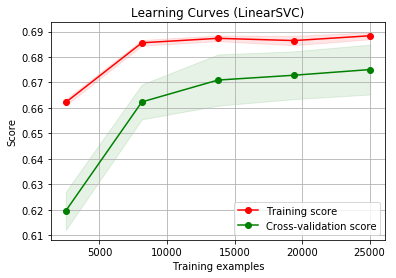

In [24]:
model_nb = result_nb[1]
title_nb = 'Learning Curves (Bernoulli Naive Bayes)' 
plot_learning_curve(model_nb, title_svc, X_train, y_train, cv=10)
# plt.savefig('../../Visuals/learningcurve_nb.png'
#             , dpi=200, bbox_inches = 'tight')

In [168]:
df_test['predicted_nb'] = result_nb[0]
df_test.head(10)

,cuisine,predicted_lr,predicted_svc,predicted_rf,predicted_nb
26745,cajun_creole,cajun_creole,cajun_creole,cajun_creole,cajun_creole
2842,mexican,mexican,mexican,mexican,mexican
36766,spanish,mexican,mexican,mexican,mexican
19107,moroccan,mexican,mexican,indian,moroccan
38651,japanese,southern_us,southern_us,southern_us,russian
11251,italian,italian,italian,italian,italian
8109,korean,italian,cajun_creole,cajun_creole,italian
20919,british,irish,southern_us,southern_us,southern_us
2472,southern_us,southern_us,southern_us,southern_us,southern_us
36048,mexican,italian,italian,southern_us,italian


In [169]:
# classification report
print(classification_report(y_test, result_nb[0]))

              precision    recall  f1-score   support

   brazilian       0.39      0.19      0.26       135
     british       0.22      0.16      0.19       221
cajun_creole       0.61      0.65      0.63       486
     chinese       0.72      0.80      0.76       778
    filipino       0.47      0.31      0.37       233
      french       0.46      0.47      0.46       774
       greek       0.65      0.57      0.61       354
      indian       0.85      0.83      0.84       876
       irish       0.35      0.19      0.25       190
     italian       0.72      0.81      0.76      2352
    jamaican       0.66      0.49      0.57       154
    japanese       0.71      0.52      0.60       459
      korean       0.70      0.60      0.64       257
     mexican       0.88      0.84      0.86      1929
    moroccan       0.82      0.71      0.76       243
     russian       0.59      0.26      0.36       156
 southern_us       0.48      0.66      0.55      1346
     spanish       0.42    

## Model Performance Summary

In [170]:
model_results = pd.DataFrame(
    {'Estimator': ['Logistic Regression','LinearSVC'
                   ,'Random Forest','Bernoulli Naive Bayes'],
     'Accuracy': [result_lr[2], result_svc[2], result_rf[2], result_nb[2]],
     'F1': [result_lr[3],result_svc[3],result_rf[3],result_nb[3]]
    })

In [171]:
model_results


,Accuracy,Estimator,F1
0,0.692450,Logistic Regression,0.572901
1,0.688092,LinearSVC,0.557349
2,0.690271,Random Forest,0.573963
3,0.668818,Bernoulli Naive Bayes,0.550126


Normalized confusion matrix
[[  2.07e-01   7.41e-03   1.48e-02   2.22e-02   1.48e-02   5.93e-02
    0.00e+00   2.22e-02   0.00e+00   1.11e-01   7.41e-03   7.41e-03
    0.00e+00   2.52e-01   0.00e+00   1.48e-02   2.22e-01   1.48e-02
    2.22e-02   0.00e+00]
 [  9.05e-03   1.45e-01   1.36e-02   4.52e-03   9.05e-03   1.76e-01
    9.05e-03   1.81e-02   5.88e-02   1.40e-01   9.05e-03   4.52e-03
    4.52e-03   3.62e-02   1.81e-02   1.81e-02   3.08e-01   1.36e-02
    4.52e-03   0.00e+00]
 [  2.06e-03   4.12e-03   6.50e-01   2.06e-03   4.12e-03   1.65e-02
    4.12e-03   4.12e-03   0.00e+00   1.05e-01   6.17e-03   0.00e+00
    0.00e+00   3.70e-02   0.00e+00   2.06e-03   1.46e-01   1.44e-02
    0.00e+00   2.06e-03]
 [  2.57e-03   0.00e+00   3.86e-03   7.96e-01   6.43e-03   3.86e-03
    2.57e-03   9.00e-03   1.29e-03   3.21e-02   3.86e-03   3.21e-02
    2.83e-02   1.41e-02   0.00e+00   0.00e+00   3.86e-02   2.57e-03
    1.54e-02   7.71e-03]
 [  8.58e-03   8.58e-03   8.58e-03   1.55e-01   3.69e-01

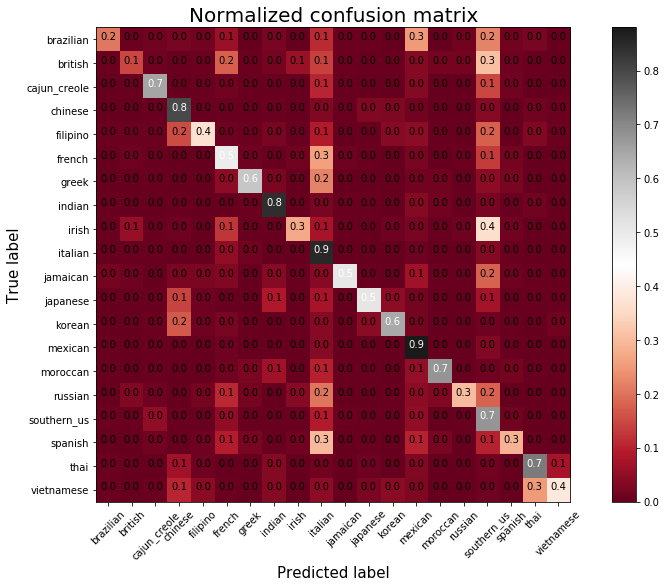

In [32]:
class_names = df_cuisine.groupby('cuisine').sum().index

# Compute confusion matrix
cnf_matrix_lr = confusion_matrix(y_test, result_lr[0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
# plt.figure()
# plt.figure(figsize=(12,8))

# plot_confusion_matrix(cnf_matrix_lr, classes=class_names
#                       ,title='Confusion matrix')


# # Plot normalized confusion matrix
plt.figure()
plt.figure(figsize=(12,8))
plot_confusion_matrix(cnf_matrix_lr, classes=class_names, normalize=True
                      ,title='Normalized confusion matrix')


# plt.savefig('../../Visuals/confusionmatrix.png'
#             , dpi=200, bbox_inches = 'tight')

# plt.savefig('../../Visuals/normalizedCM.png'
#             , dpi=200, bbox_inches = 'tight')

#### Flask Preparation

In [13]:
PREDICTOR = LogisticRegression(C=10).fit(X_train,y_train)

In [14]:
# with open('../../Data/bestestimator.pickle', 'wb') as handle: 
#     pickle.dump(PREDICTOR, handle, pickle.HIGHEST_PROTOCOL)